# Solution with Machine Learning  

# 1. Import Python libraries

In [1]:
# used to change filepaths
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

# import Image from PIL

from PIL import Image 
from skimage.feature import hog
from skimage.color import rgb2gray

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# import train_test_split from sklearn's model selection module
# ... YOUR CODE FOR TASK 1 ...
from sklearn.model_selection import train_test_split
# import SVC from sklearn's svm module

from sklearn.svm import SVC
# import accuracy_score from sklearn's metrics module
from sklearn.metrics import roc_curve, auc, accuracy_score

# 2. Display image of each bee type

,genus
id,
520,1.0
3800,1.0
3289,1.0
2695,1.0
4922,1.0


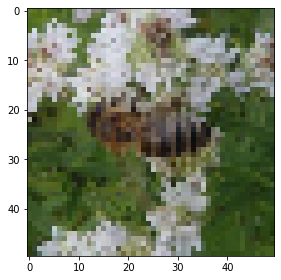

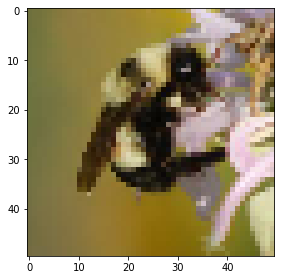

In [2]:
# load the labels using pandas
labels = pd.read_csv("datasets/labels.csv", index_col=0)

# show the first five rows of the dataframe using head
display(labels.head())

def get_image(row_id, root="datasets/"):
    """
    Converts an image number into the file path where the image is located, 
    opens the image, and returns the image as a numpy array.
    """
    filename = "{}.jpg".format(row_id)
    file_path = os.path.join(root, filename)
    img = Image.open(file_path)
    return np.array(img)

# subset the dataframe to just Apis (genus is 0.0) get the value of the sixth item in the index
apis_row = labels[labels.genus == 0.0].index[5]

# show the corresponding image of an Apis
plt.imshow(get_image(apis_row))
plt.show()

# subset the dataframe to just Bombus (genus is 1.0) get the value of the sixth item in the index
bombus_row = labels[labels.genus == 1.0].index[5]

# show the corresponding image of a Bombus
plt.imshow(get_image(bombus_row))
plt.show()

# 3. Image manipulation with rgb2gray

Color bombus image has shape:  (50, 50, 3)
Grayscale bombus image has shape:  (50, 50)


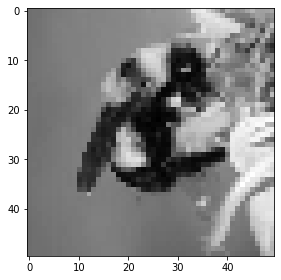

In [3]:
# load a bombus image using our get_image function and bombus_row from the previous cell
bombus = get_image(bombus_row)

# print the shape of the bombus image
print('Color bombus image has shape: ', bombus.shape)

# convert the bombus image to grayscale
gray_bombus = rgb2gray(bombus)

# show the grayscale image
plt.imshow(gray_bombus, cmap=mpl.cm.gray)

# grayscale bombus image only has one channel
print('Grayscale bombus image has shape: ', gray_bombus.shape)

# 4. Histogram of oriented gradients

<p>We've got a matrix of pixel values, but those don't contain enough interesting information on their own for most algorithms. We need to help the algorithms along by picking out some of the salient features for them using the <a href="http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html">histogram of oriented gradients</a> (HOG) descriptor. The idea behind <a href="https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients">HOG</a> is that an object's shape within an image can be inferred by its edges, and a way to identify edges is by looking at the direction of intensity gradients (i.e. changes in luminescence). </p>
<p><img src="https://assets.datacamp.com/production/project_412/img/hog.png" alt="HOG"></p>
<p>An image is divided in a grid fashion into cells, and for the pixels within each cell, a histogram of gradient directions is compiled. To improve invariance to highlights and shadows in an image, cells are block normalized, meaning an intensity value is calculated for a larger region of an image called a block and used to contrast normalize all cell-level histograms within each block. The HOG feature vector for the image is the concatenation of these cell-level histograms.</p>

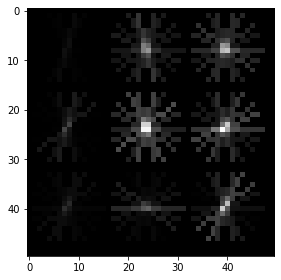

In [4]:
# run HOG using our grayscale bombus image
hog_features, hog_image = hog(gray_bombus,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))

# show our hog_image with a gray colormap
plt.imshow(hog_image, cmap=mpl.cm.gray)

# 5. Create image features and flatten into a single row

In [5]:
def create_features(img):
    # flatten three channel color image
    color_features = img.flatten()
    # convert image to grayscale
    gray_image = rgb2gray(img)
    # get HOG features from grayscale image
    hog_features = hog(gray_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    # combine color and hog features into a single array
    flat_features = np.hstack((color_features,hog_features))
    return flat_features

bombus_features = create_features(bombus)

# print shape of bombus_features

print(bombus_features.shape)

(7581,)


# 6. Loop over images to preprocess

In [6]:
def create_feature_matrix(label_dataframe):
    features_list = []
    
    for img_id in label_dataframe.index:
        # load image
        img = get_image(img_id)
        # get features for image
        image_features = create_features(img)
        features_list.append(image_features)
        
    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix

# run create_feature_matrix on our dataframe of images
feature_matrix = create_feature_matrix(labels)

# 7. Split into train and test sets

In [7]:
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(feature_matrix,
                                                    labels.genus.values,
                                                    test_size=.3,
                                                    random_state=1234123)

# look at the distribution of labels in the train set
# ... YOUR CODE FOR TASK 7
y_train_series=pd.Series(y_train)
y_train_series.value_counts()

1.0    588
0.0    569
dtype: int64

# 8. Scale training and test features

In [8]:
# get shape of our training features
print('Training features matrix shape is: ', X_train.shape)

# define standard scaler
ss = StandardScaler()

# fit the scaler and transform the training features
train_stand = ss.fit_transform(X_train)

# transform the test features
test_stand = ss.transform(X_test)

# look at the new shape of the standardized feature matrices
print('Standardized training features matrix shape is: ', train_stand.shape)
print('Standardized test features matrix shape is: ', test_stand.shape)

Training features matrix shape is:  (1157, 7581)
Standardized training features matrix shape is:  (1157, 7581)
Standardized test features matrix shape is:  (497, 7581)


# 9. Perform PCA

<p>Remember also that we have over 31,000 features for each image and only 500 images total. To use an SVM, our model of choice, we also need to reduce the number of features we have using <a href="http://scikit-learn.org/stable/modules/decomposition.html#pca">principal component analysis</a> (PCA). </p>
<p>PCA is a way of linearly transforming the data such that most of the information in the data is contained within a smaller number of features called components. Below is a visual <a href="https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60">example</a> from an image dataset containing handwritten numbers. The image on the left is the original image with 784 components. We can see that the image on the right (post PCA) captures the shape of the number quite effectively even with only 59 components.</p>
<p><img src="https://assets.datacamp.com/production/project_412/img/pca_cropped.png" alt="PCA"></p>
<p>In our case, we will keep 350 components. This means our feature matrices <code>train_stand</code> and <code>test_stand</code> will only have 350 columns, rather than the original of 31,296. Let's start by scaling and performing PCA on our training features. </p>
<hr>

In [9]:
# Instantiate a PCA object with 350 components
pca = PCA(n_components=350)

# use fit_transform on our standardized training features
X_train = pca.fit_transform(train_stand)

# use transform on our standardized test features
X_test = pca.transform(test_stand)

# look at new shape
print('Training features matrix is: ', X_train.shape)
print('Test features matrix is: ', X_test.shape)

Training features matrix is:  (1157, 350)
Test features matrix is:  (497, 350)


# 10.Train and score our model


In [10]:
# define support vector classifier
svm = SVC(probability=True,random_state=42)

# fit model
# ... YOUR CODE FOR TASK 10 ...
svm.fit(X_train,y_train)
# generate predictions
y_pred = svm.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test,y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.48893360160965793


# 11. ROC curve + AUC

Using the default settings, probabilities of 0.5 or above are assigned a class label of 1.0 and those below are assigned a 0.0. However, this threshold can be adjusted. The receiver operating characteristic curve (ROC curve) plots the false positive rate and true positive rate at different thresholds. ROC curves are judged visually by how close they are to the upper lefthand corner.

The area under the curve (AUC) is also calculated, where 1 means every predicted label was correct. Generally, the worst score for AUC is 0.5, which is the performance of a model that randomly guesses. See the scikit-learn documentation for more resources and examples on ROC curves and AUC.

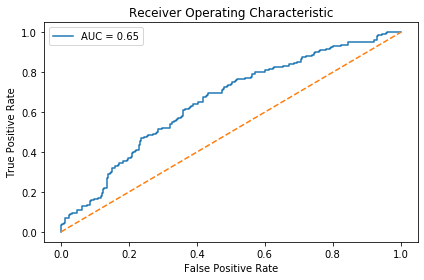

In [11]:
# predict probabilities for X_test using predict_proba
probabilities = svm.predict_proba(X_test)

# select the probabilities for label 1.0
y_proba = probabilities[:, 1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

# Solution with Deep Learning 

## 1. Import Python libraries
<p><img src="https://assets.datacamp.com/production/project_555/img/92_notebook.jpg" alt="honey bee">
<em>A honey bee (Apis).</em></p>
<p>Can a machine identify a bee as a honey bee or a bumble bee? These bees have different <a href="https://www.thesca.org/connect/blog/bumblebees-vs-honeybees-what%E2%80%99s-difference-and-why-does-it-matter">behaviors and appearances</a>, but given the variety of backgrounds, positions, and image resolutions, it can be a challenge for machines to tell them apart.</p>
<p>Being able to identify bee species from images is a task that ultimately would allow researchers to more quickly and effectively collect field data. Pollinating bees have critical roles in both ecology and agriculture, and diseases like <a href="http://news.harvard.edu/gazette/story/2015/07/pesticide-found-in-70-percent-of-massachusetts-honey-samples/">colony collapse disorder</a> threaten these species. Identifying different species of bees in the wild means that we can better understand the prevalence and growth of these important insects.</p>
<p><img src="https://assets.datacamp.com/production/project_555/img/20_notebook.jpg" alt="bumble bee">
<em>A bumble bee (Bombus).</em></p>
<p>This notebook walks through building a simple deep learning model that can automatically detect honey bees and bumble bees and then loads a pre-trained model for evaluation.</p>

In [6]:
import pickle
from pathlib import Path
from skimage import io

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# import keras library

import keras  
# import Sequential from the keras models module

from keras.models import Sequential
# import Dense, Dropout, Flatten, Conv2D, MaxPooling2D from the keras layers module
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

## 2. Load image labels
<p>Now that we have all of our imports ready, it is time to look at the labels for our data. We will load our <code>labels.csv</code> file into a DataFrame called <code>labels</code>, where the index is the image name (e.g. an index of 1036 refers to an image named 1036.jpg) and the <code>genus</code> column tells us the bee type. <code>genus</code> takes the value of either <code>0.0</code> (Apis or honey bee) or <code>1.0</code> (Bombus or bumble bee).</p>

In [7]:
# load labels.csv from datasets folder using pandas
labels = pd.read_csv("datasets/labels.csv",index_col=0)

# print value counts for genus
print(labels['genus'].value_counts())

# assign the genus label values to y
y = labels['genus'].values

0.0    827
1.0    827
Name: genus, dtype: int64


## 3. Examine RGB values in an image matrix
<p>Image data can be represented as a matrix. The width of the matrix is the width of the image, the height of the matrix is the height of the image, and the depth of the matrix is the number of channels. Most image formats have three color channels: red, green, and blue.</p>
<p>For each pixel in an image, there is a value for every channel. The combination of the three values corresponds to the color, as per the <a href="https://en.wikipedia.org/wiki/RGB_color_model">RGB color model</a>. Values for each color can range from 0 to 255, so a purely blue pixel would show up as (0, 0, 255).</p>
<p><img src="https://assets.datacamp.com/production/project_555/img/rgb_example.png" width="600"></p>
<p>Let's explore the data for a sample image. </p>

Example image has shape:  (50, 50, 3)
RGB values for the top left pixel are: 127


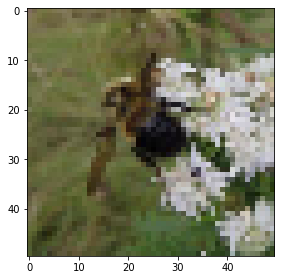

In [8]:
# load an image and explore
example_image = io.imread('datasets/{}.jpg'.format(labels.index[0]))

# show image

plt.imshow(example_image)
# print shape
print('Example image has shape: ', example_image.shape)
                    
# print color channel values for top left pixel
print('RGB values for the top left pixel are:', example_image[0,0,0])

## 4. Importing the image data
<p>Now we will import all images. Once imported, we will stack the resulting arrays into a single matrix and assign it to <code>X</code>.</p>

In [9]:
# create empty list
image_list = []

for i in labels.index:
    # load image
    img = io.imread('datasets/{}.jpg'.format(i)).astype(np.float64)
        
    # append to list of all images
    image_list.append(img)
    
# convert image list to single array
X = np.array(image_list)

print(X.shape)

(1654, 50, 50, 3)


## 5. Split into train, test, and evaluation sets
<p>Now that we have our big image data matrix, <code>X</code>, as well as our labels, <code>y</code>, we can split our data into train, test, and evaluation sets. To do this, we'll first allocate 20% of the data into our evaluation, or holdout, set. This is data that the model never sees during training and will be used to score our trained model.</p>
<p>We will then split the remaining data, 60/40, into train and test sets just like in supervised machine learning models. We will pass both the train and test sets into the neural network. </p>

In [10]:
# split out evaluation sets (x_eval and y_eval)
x_interim, x_eval, y_interim, y_eval = train_test_split(X,
                                           y,
                                           test_size=0.2,
                                           random_state=52)

# split remaining data into train and test sets
# ... YOUR CODE FOR TASK 5 ...
x_train, x_test, y_train, y_test=train_test_split(x_interim,y_interim,test_size=0.4,random_state=52)
# examine number of samples in train, test, and validation sets
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_eval.shape[0], 'eval samples')

x_train shape: (793, 50, 50, 3)
793 train samples
530 test samples
331 eval samples


## 6. Normalize image data
<p>Now we need to normalize our image data. Normalization is a general term that means changing the scale of our data so it is consistent.</p>
<p>In this case, we want each feature to have a similar range so our neural network can learn effectively across all the features. As explained in the <a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html">sklearn docs</a>, "If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected."</p>
<p>We will scale our data so that it has a mean of 0 and standard deviation of 1. We'll use sklearn's <code>StandardScaler</code> to do the math for us, which entails taking each value, subtracting the mean, and then dividing by the standard deviation. We need to do this for each color channel (i.e. each feature) individually. </p>

In [11]:
# initialize standard scaler
ss = StandardScaler()

def scale_features(train_features, test_features):
    for image in train_features:
        # for each channel, apply standard scaler's fit_transform method
        for channel in range(image.shape[2]):
            image[:, :, channel] = ss.fit_transform(image[:, :, channel])
    for image in test_features:
        # for each channel, apply standard scaler's transform method
        for channel in range(image.shape[2]):
            image[:, :, channel] = ss.transform(image[:, :, channel])

# apply scale_features to four sets of features
scale_features(x_interim,x_eval)
scale_features(x_train, x_test)

## 7. Model building (part i)
<p>It's time to start building our deep learning model, a convolutional neural network (CNN). CNNs are a specific kind of artificial neural network that is very effective for image classification because they are able to take into account the spatial coherence of the image, i.e., that pixels close to each other are often related.</p>
<p>Building a CNN begins with specifying the model type. In our case, we'll use a <a href="https://keras.io/getting-started/sequential-model-guide/">Sequential</a> model, which is a linear stack of layers. We'll then add two convolutional layers. To understand convolutional layers, imagine a flashlight being shown over the top left corner of the image and slowly sliding across all the areas of the image, moving across the image in the same way your eyes move across words on a page. Convolutional layers pass a kernel (a sliding window) over the image and perform element-wise matrix multiplication between the kernel values and the pixel values in the image.</p>

In [12]:
# set model constants
num_classes = 1

# define model as Sequential
model = Sequential()

# first convolutional layer with 32 filters
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(50, 50, 3)))

# add a second 2D convolutional layer with 64 filters

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

## 8. Model building (part ii)
<p>Let's continue building our model. So far our model has two convolutional layers. However, those are not the only layers that we need to perform our task. A complete neural network architecture will have a number of other layers that are designed to play a specific role in the overall functioning of the network. Much deep learning research is about how to structure these layers into coherent systems.</p>
<p>We'll add the following layers:</p>
<ul>
<li><a href="https://keras.io/layers/pooling/#maxpooling2d"><code>MaxPooling</code></a>. This passes a (2, 2) moving window over the image and downscales the image by outputting the maximum value within the window.</li>
<li><a href="https://keras.io/layers/convolutional/#conv2d"><code>Conv2D</code></a>. This adds a third convolutional layer since deeper models, i.e. models with more convolutional layers, are better able to learn features from images.</li>
<li><a href="https://keras.io/layers/core/#dropout"><code>Dropout</code></a>. This prevents the model from overfitting, i.e. perfectly remembering each image, by randomly setting 25% of the input units to 0 at each update during training.</li>
<li><a href="https://keras.io/layers/core/#flatten"><code>Flatten</code></a>. As its name suggests, this flattens the output from the convolutional part of the CNN into a one-dimensional feature vector which can be passed into the following fully connected layers.</li>
<li><a href="https://keras.io/layers/core/#dense"><code>Dense</code></a>. Fully connected layer where every input is connected to every output (see image below).</li>
<li><a href="https://keras.io/layers/core/#dropout"><code>Dropout</code></a>. Another dropout layer to safeguard against overfitting, this time with a rate of 50%.</li>
<li><code>Dense</code>. Final layer which calculates the probability the image is either a bumble bee or honey bee.</li>
</ul>
<p>To take a look at how it all stacks up, we'll print the model summary. Notice that our model has a whopping <code>3,669,249</code> paramaters. These are the different weights that the model learns through training and what are used to generate predictions on a new image.</p>
<p><img src="https://assets.datacamp.com/production/project_555/img/mlp_conv.png" alt></p>

In [13]:
# reduce dimensionality through max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# third convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# add dropout to prevent over fitting
model.add(Dropout(0.25))
# necessary flatten step preceeding dense layer
model.add(Flatten())
# fully connected layer
model.add(Dense(128, activation='relu'))

# add additional dropout to prevent overfitting

model.add(Dropout(0.5))
# prediction layers
model.add(Dense(num_classes, activation='sigmoid', name='preds'))

# show model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 21, 21, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28224)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3

## 9. Compile and train model
<p>Now that we've specified the model architecture, we will <a href="https://keras.io/models/model/#compile">compile</a> the model for training. For this we need to specify the loss function (what we're trying to minimize), the optimizer (how we want to go about minimizing the loss), and the metric (how we'll judge the performance of the model).</p>
<p>Then, we'll call <a href="https://keras.io/models/model/#fit"><code>.fit</code></a> to begin the trainig the process. </p>
<blockquote>
  <p>"Neural networks are trained iteratively using optimization techniques like gradient descent. After each cycle of training, an error metric is calculated based on the difference between prediction and target…Each neuron’s coefficients (weights) are then adjusted relative to how much they contributed to the total error. This process is repeated iteratively." <a href="https://ml-cheatsheet.readthedocs.io/en/latest/nn_concepts.html">ML Cheatsheet</a></p>
</blockquote>
<p>Since training is computationally intensive, we'll do a 'mock' training to get the feel for it, using just the first 10 images in the train and test sets and training for just 5 epochs. Epochs refer to the number of iterations over the data. Typically, neural networks will train for hundreds if not thousands of epochs.</p>
<p>Take a look at the printout for each epoch and note the loss on the train set (<code>loss</code>), the accuracy on the train set (<code>acc</code>), and loss on the test set (<code>val_loss</code>) and the accuracy on the test set (<code>val_acc</code>). We'll explore this more in a later step.</p>

In [14]:
model.compile(
    # set the loss as binary_crossentropy
    loss=keras.losses.binary_crossentropy,
    # set the optimizer as stochastic gradient descent
    optimizer=keras.optimizers.SGD(lr=0.001),
    # set the metric as accuracy
    metrics=['accuracy']
)

# mock-train the model using the first ten observations of the train and test sets
model.fit(
    x_train[:10, :, :, :],
    y_train[:10],
    epochs=5,
    verbose=1,
    validation_data=(x_test[:10, :, :, :], y_test[:10])
)

Epoch 1/5
1/1 [==============================] - 1s 964ms/step - loss: 0.6025 - accuracy: 0.7000 - val_loss: 0.7744 - val_accuracy: 0.5000
Epoch 2/5
1/1 [==============================] - 0s 98ms/step - loss: 0.6913 - accuracy: 0.6000 - val_loss: 0.7818 - val_accuracy: 0.5000
Epoch 3/5
1/1 [==============================] - 0s 99ms/step - loss: 0.6317 - accuracy: 0.7000 - val_loss: 0.7886 - val_accuracy: 0.5000
Epoch 4/5
1/1 [==============================] - 0s 83ms/step - loss: 0.5793 - accuracy: 0.7000 - val_loss: 0.7996 - val_accuracy: 0.5000
Epoch 5/5
1/1 [==============================] - 0s 81ms/step - loss: 0.6036 - accuracy: 0.7000 - val_loss: 0.8112 - val_accuracy: 0.5000


## 10. Load pre-trained model and score
<p>Now we'll load a pre-trained model that has the architecture we specified above and was trained for 200 epochs on the full train and test sets we created above.</p>
<p>Let's use the <a href="https://keras.io/models/model/#evaluate"><code>evaluate</code></a> method to see how well the model did at classifying bumble bees and honey bees for the test and validation sets.  Recall that accuracy is the number of correct predictions divided by the total number of predictions. Given that our classes are balanced, a model that predicts <code>1.0</code> for every image would get an accuracy around <code>0.5</code>.</p>
<p>Note: it may take a few seconds to load the model. Recall that our model has over 3 million parameters (weights), which are what's being loaded.</p>

In [15]:
# load pre-trained model
pretrained_cnn = keras.models.load_model('datasets/pretrained_model.h5')

# evaluate model on test set
score = pretrained_cnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("")

# evaluate model on holdout set
eval_score = pretrained_cnn.evaluate(x_eval,y_eval)
# print loss score
print('Eval loss:', eval_score[0])
# print accuracy score
print('Eval accuracy:',eval_score[1])

Test loss: 0.6719561815261841
Test accuracy: 0.6188679337501526

11/11 [==============================] - 0s 24ms/step - loss: 0.6702 - accuracy: 0.6375
Eval loss: 0.6701620221138
Eval accuracy: 0.6374622583389282


## 11. Visualize model training history
<p>In addition to scoring the final iteration of the pre-trained model as we just did, we can also see the evolution of scores throughout training thanks to the <a href="https://keras.io/callbacks/#history"><code>History</code></a> object. We'll use the <a href="https://docs.python.org/3/library/pickle.html"><code>pickle</code></a> library to load the model history and then plot it.</p>
<p>Notice how the accuracy improves over time, eventually leveling off. Correspondingly, the loss decreases over time. Plots like these can help diagnose overfitting. If we had seen an upward curve in the validation loss as times goes on (a U shape in the plot), we'd suspect that the model was starting to memorize the test set and would not generalize well to new data.</p>

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


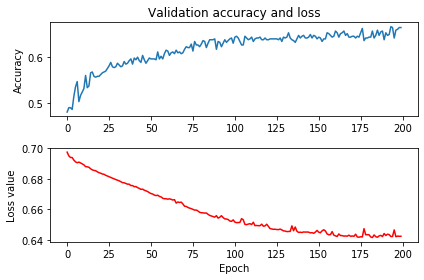

In [16]:
# load history
with open('datasets/model_history.pkl', 'rb') as f:
    pretrained_cnn_history = pickle.load(f)

# print keys for pretrained_cnn_history dict
print(pretrained_cnn_history.keys())

fig = plt.figure(1)
plt.subplot(211)
# plot the validation accuracy
plt.plot(pretrained_cnn_history['val_acc'])
plt.title('Validation accuracy and loss')
plt.ylabel('Accuracy')
plt.subplot(212)
# plot the validation loss
plt.plot(pretrained_cnn_history['val_loss'], 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss value');

## 12. Generate predictions
<p>Previously, we calculated an overall score for our pre-trained model on the validation set. To end this notebook, let's access probabilities and class predictions for individual images using the <code>.predict()</code> method and <code>np.round()</code>.</p>
<p>We now have a deep learning model that can be used to identify honey bees and bumble bees in images! The next step is to explore transfer learning, which harnesses the prediction power of models that have been trained on far more images than the mere 1600 in our dataset.</p>

In [17]:
# predicted probabilities for x_eval
y_proba = pretrained_cnn.predict(x_eval)

print("First five probabilities:")
print(y_proba[:5])
print("")

# predicted classes for x_eval
y_pred = np.round(y_proba).astype('int')

print("First five class predictions:")
print(y_pred[:5])
print("")

First five probabilities:
[[0.51043946]
 [0.5508864 ]
 [0.6333447 ]
 [0.18111488]
 [0.3395769 ]]

First five class predictions:
[[1]
 [1]
 [1]
 [0]
 [0]]

